In [1]:
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os
import cv2
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
path_train_high = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\train\high_res'
path_train_low = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\train\low_res'
path_val_high = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\val\high_res'
path_val_low = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\AUTOENCONDER\dataset\val\low_res'

In [4]:
#### Funcion para leer imagenes dentro de una carpeta
width = 256
height = 256
def imageReading (path):
    folderFilesids = os.listdir(path)
    images = np.zeros((len(folderFilesids), height, width))
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1)
        if (len(originalImage.shape)==2):
            originalImage = imread(path1)[:,:]
        if (len(originalImage.shape)==3):
            originalImage = imread(path1)[:,:,0]
        #print(originalImage.shape)
        images[count] = originalImage
    imshow(images[0])
    plt.show()
    return images

C:\Users\ASUS\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


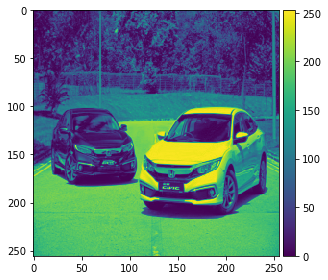

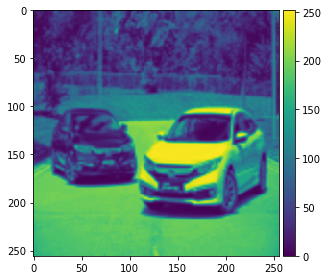

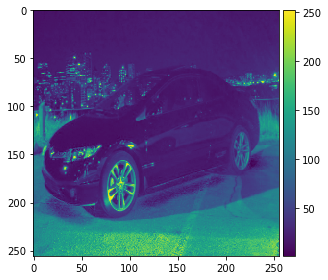

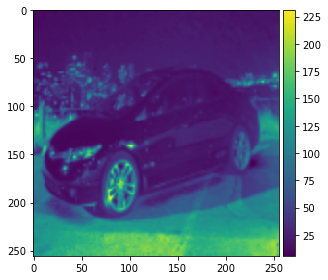

In [5]:
train_high = imageReading (path_train_high)
train_low = imageReading (path_train_low)
val_high = imageReading (path_val_high)
val_low = imageReading (path_val_low)

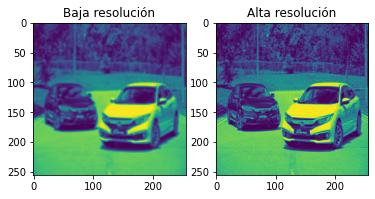

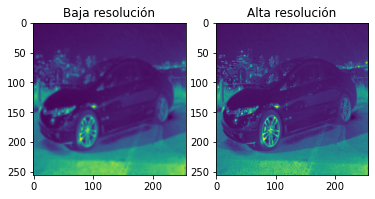

In [6]:
plt.figure(1)
plt.subplot(122)
plt.imshow(np.reshape(train_high[0],(256,256))),plt.title('Alta resolución')
plt.subplot(121),plt.imshow(np.reshape(train_low[0],(256,256))), plt.title('Baja resolución')
plt.show()
plt.figure(2)
plt.subplot(122)
plt.imshow(np.reshape(val_high[0],(256,256))),plt.title('Alta resolución')
plt.subplot(121),plt.imshow(np.reshape(val_low[0],(256,256))), plt.title('Baja resolución')
plt.show()


In [7]:
train_high.shape

(685, 256, 256)

In [8]:
train_high = torch.from_numpy(np.array(train_high).reshape(-1,1,256,256)).float() 
train_low = torch.from_numpy(np.array(train_low).reshape(-1,1,256,256)).float()
val_high = torch.from_numpy(np.array(val_high).reshape(-1,1,256,256)).float() 
val_low = torch.from_numpy(np.array(val_low).reshape(-1,1,256,256)).float()

In [41]:
img_train = []
for i in range(train_high.shape[0]):
      img_train.append(((((train_low[i]/255.0)-0.5)*2),(((train_high[i]/255.0)-0.5)*2)))
        
img_val = []
for i in range(val_high.shape[0]):
      img_val.append(((((val_low[i]/255.0)-0.5)*2),(((val_high[i]/255.0)-0.5)*2)))


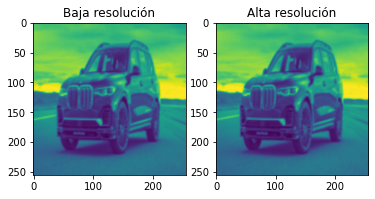

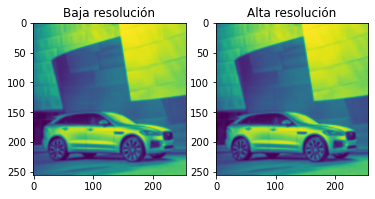

In [42]:
plt.figure(3)
plt.subplot(122)
plt.imshow(np.reshape(img_train[10][0],(256,256))),plt.title('Alta resolución')
plt.subplot(121),plt.imshow(np.reshape(train_low[10][0],(256,256))), plt.title('Baja resolución')
plt.show()
plt.figure(4)
plt.subplot(122)
plt.imshow(np.reshape(img_val[5][0],(256,256))),plt.title('Alta resolución')
plt.subplot(121),plt.imshow(np.reshape(img_val[5][0],(256,256))), plt.title('Baja resolución')
plt.show()


In [43]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=img_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=img_val, batch_size=batch_size, shuffle=True)


### Modelo

#### Modelo 1

In [60]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=4, padding=2) #65x65 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32*2, kernel_size=5, stride=4, padding=0)#16x16
        self.fc = nn.Linear(in_features=32*2*16*16, out_features=100)
    def forward(self, image):
        #print("image",image.shape)
        out = F.relu(self.conv1(image))
        #print("convolucion1",out.shape)
        out = F.relu(self.conv2(out))
        #print("convolucion2",out.shape)
        out = out.view(out.size(0), -1)
        #print("MLP",out.shape)
        z = self.fc(out)
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc    = nn.Linear(in_features=100,out_features=2*32*16*16)
        #print("lineal1",self.fc.shape)
        self.convTran1 = nn.ConvTranspose2d(in_channels=2*32,out_channels=32, kernel_size=5, stride=4, padding=0)
        #print("lineal1",self.convTran1.shape)
        self.convTran2 = nn.ConvTranspose2d(in_channels=32,out_channels=1, kernel_size=4, stride=4, padding=2)
        #print("lineal1",self.convTran2.shape)
   
    def forward(self, latent):
        out = self.fc(latent)
        #print("MLP",out.shape)
        out = out.view(out.size(0), 32*2, 16, 16)
        #print("decon1",out.shape)
        out = F.relu(self.convTran1(out))
        #print("decon1",out.shape)
        out = torch.tanh(self.convTran2(out))
        #print("decon1",out.shape)
        return out

In [61]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x.float())
        x_recon = self.decoder(latent)
        return  x_recon

#### entrenamiento

In [62]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        
        for image_batch_high,image_batch_low in train_loader:
            image_batch_high = image_batch_high.to(device)
            image_batch_low = image_batch_low.to(device)
            
            #print(image_batch.size())
            #print(image_batch)
            
            image_batch_recon = model(image_batch_high)
            # print(image_batch_recon.size())        
           
            
            loss = loss_fn(image_batch_recon, image_batch_low)
            #print("el loss es :",loss)  
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
            train_loss_avg[-1] += loss.item()
            num_batches += 1
          
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
        
    return train_loss_avg

In [63]:
   
learning_rate = 0.001
autoencoder = Autoencoder().float()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()


loss_result = train(autoencoder,train_loader,10,loss)

Epoch [1 / 10] average reconstruction error: 0.262218
Epoch [2 / 10] average reconstruction error: 0.153513
Epoch [3 / 10] average reconstruction error: 0.125492
Epoch [4 / 10] average reconstruction error: 0.111412
Epoch [5 / 10] average reconstruction error: 0.101827
Epoch [6 / 10] average reconstruction error: 0.095233
Epoch [7 / 10] average reconstruction error: 0.089445
Epoch [8 / 10] average reconstruction error: 0.084357
Epoch [9 / 10] average reconstruction error: 0.080444
Epoch [10 / 10] average reconstruction error: 0.076992


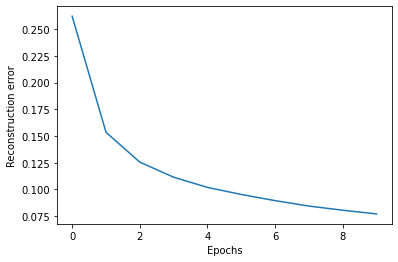

In [64]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [65]:
def Show(out, title = ''):
    print(title)
    out = out.permute(1,0,2,3)
    grilla = torchvision.utils.make_grid(out,10,5)
    plt.imshow(transforms.ToPILImage()(grilla), 'jet')
    plt.show()

def Show_Weight(out):
    grilla = torchvision.utils.make_grid(out)
    plt.imshow(transforms.ToPILImage()(grilla), 'jet')
    plt.show()

In [68]:
capacity = 64
latent_dims = 100 
autoencoder.eval()


tensor = torch.zeros(len(val_loader),10)


with torch.no_grad():

    image,label = iter(val_loader).next()
    image,label = iter(val_loader).next()
    image = image.to(device)
    z = autoencoder.encoder(image) # Solo decoder para sacar el Z
    z = z.to('cpu')
    mean = z.mean(dim=0)

    std = (z - mean).pow(2).mean(dim=0).sqrt()

    z1 = torch.randn(5, latent_dims)*std + mean
    z1 = z1.to(device)
    decodificado = autoencoder.decoder(z1)



    decodificado = decodificado.to('cpu')

    fig, ax = plt.subplots(figsize=(256, 256))
    Show_Weight(decodificado[1:5])
    plt.show()
    fig, ax = plt.subplots(figsize=(256, 256))
    Show_Weight(image[1:5])
    plt.show()